## Introduction
Every once in a while, a python library is developed that has the potential of changing the landscape in the field of Deep Learning. PyTorch is one such library. In the last few weeks, I have been dabbling a bit in PyTorch. I have been blown away by how easy it is to grasp. Among the various deep learning libraries I have used till date – PyTorch has been the most flexible and effortless of them all.

Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Let's get straight into it

[Original Notebook](https://www.kaggle.com/code/abhinand05/mnist-introduction-to-computervision-with-pytorch)

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting beautiful graphs

# train test split from sklearn
from sklearn.model_selection import train_test_split

# Import Torch 
import torch
import torch.nn as nn
from torchvision import transforms, models
# from torch.utils.data import SubsetRandomSampler
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F

# plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'

C:\Users\radiu\anaconda3\envs\courses\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import the Data

In [2]:
train = pd.read_csv("../mnist/digit-recognizer/train.csv")
final_test = pd.read_csv("../mnist/digit-recognizer/test.csv")
sample_sub = pd.read_csv("../mnist/digit-recognizer/sample_submission.csv")
train.label.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


## Preparing Dataset
* What we are doing here is taking the raw dataset and splitting into targets and features. Dividing by 255 makes each pixel value to scale between 0 and 1 instead of 0 and 255, which helps in training our model. This step in Machine Learning is generally known as Normalization. Then we split into train and test sets using sklearn's train_test_split function.

* Converting the numpy arrays into PyTorch Tensors using from_numpy function. Don’t let the word “tensor” scare you. It is nothing more than a simple mathematical concept. Tensors are mathematical objects that generalize scalars, vectors and matrices to higher dimensions.

* Batch size is set. The batch size is usually set between 64 and 256. The batch size does have an effect on the final test accuracy. One way to think about it is that smaller batches means that the number of parameter updates per epoch is greater. 

* To pass our data into our PyTorch models we need to convert it to a PyTorch Dataset. A Tensor Dataset in this case. 

* We have the training data loaded into trainloader and we can make an iterator with iter(trainloader) that can help us grab data. Later, we'll use this to loop through the dataset for training. Each time we can pull out data of the size of the batch that is defined.

In [4]:
# Separate the features and labels
targets_np = train["label"]
pureimg_train = train.drop(labels = ["label"], axis = 1) # drop the label column
del train # no longer needed
features_np = pureimg_train/255

# Split into training and test set
feature_train, feature_test, target_train, target_test = train_test_split(features_np, targets_np, test_size=0.2, random_state=42)


In [5]:
# Create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore, first we create a tensor, then we will create a variable.
featuresTrain = torch.from_numpy(feature_train.values.reshape((-1,1,28,28)))
targetsTrain = torch.from_numpy(target_train.values)

# Create feature and targets tensor for test set.
featuresTest = torch.from_numpy(feature_test.values.reshape((-1,1,28,28)))
targetsTest = torch.from_numpy(target_test.values) # data type is long

In [6]:
# Set batch size
batch_size = 256
test_batch_size = 256

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain.float(), targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest.float(), targetsTest)

# Define train and test data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, shuffle=True)

In [7]:
# # Visualize one of the images in data set
# def visualize_image(data, index, pred=False, val=0):
#     """
#     This function can be used to visualize the images
#     """
#     plt.imshow(data[index])
#     plt.axis("off")
#     plt.title("Handwritten Digit Image")
#     plt.show()
#
# visualize_image(features_np, index=1)


In [8]:
featuresTrain.shape

torch.Size([33600, 1, 28, 28])

## Define Network Architecture


In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

## Training and Validation 

Now we should create our own network and train it. First we'll want to define the criterion (something like nn.CrossEntropyLoss or nn.NLLLoss) and the optimizer (typically optim.SGD or optim.Adam).
* Make a forward pass through the network
* Use the network output to calculate the loss
* Perform a backward pass through the network with loss.backward() to calculate the gradients
* Take a step with the optimizer to update the weights

In [10]:
# Instantiate our model
model = CNNModel()
# Define our loss function
criterion = nn.NLLLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 2
steps = 0
print_every = 100
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        # Make predictions
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        # Backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    # Get our top predictions
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))


Epoch: 1/2..  Training Loss: 0.396..  Test Loss: 0.132..  Test Accuracy: 0.960
Epoch: 2/2..  Training Loss: 0.071..  Test Loss: 0.076..  Test Accuracy: 0.976


Oh what just happended there? I'll explain not to worry.

#### Training: 
* I'm looping over the train loader, pulling out the images and labels.
* Note that I have a line of code optimizer.zero_grad(). When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.
* I have named the next variable log_ps because our model gives us back logs of class probabilities, you can take exponent to convert it to normal probabilities which I've done down below for validation. 
* We calculate the loss. Then backpropagate through the network. We then make one optimizer step. Which brings us closer and closer to the global optimum.

#### Validation
* We turn off the gradients for validation as it is not needed and saves a lot of memory and computation. Note that we should turn it back on after each step of validation.
* We loop over the test_loader and essentially repeat some steps we have done above. Since it's validation we don't need to backpropagate. 
* The next step - With the probabilities, we can get the most likely class using the ps.topk method. This returns the $k$ highest values. Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.
* Then we check if the predicted value is equal to the actual value. 
* We then calculate the percentage of correct predictions, which indeed is using the mean of our top predictions. But you cannot just use torch.mean because topk returns a byte tensor but we need a float tensor to perform torch.mean we do that in the next step.

The same process is repeated over and over again. The results are printed on each step. With this simple model we're able to get about 98% accuracy on validation which is awesome, isn't it?

Hope that made sense. 

## Visualizing Model Performance

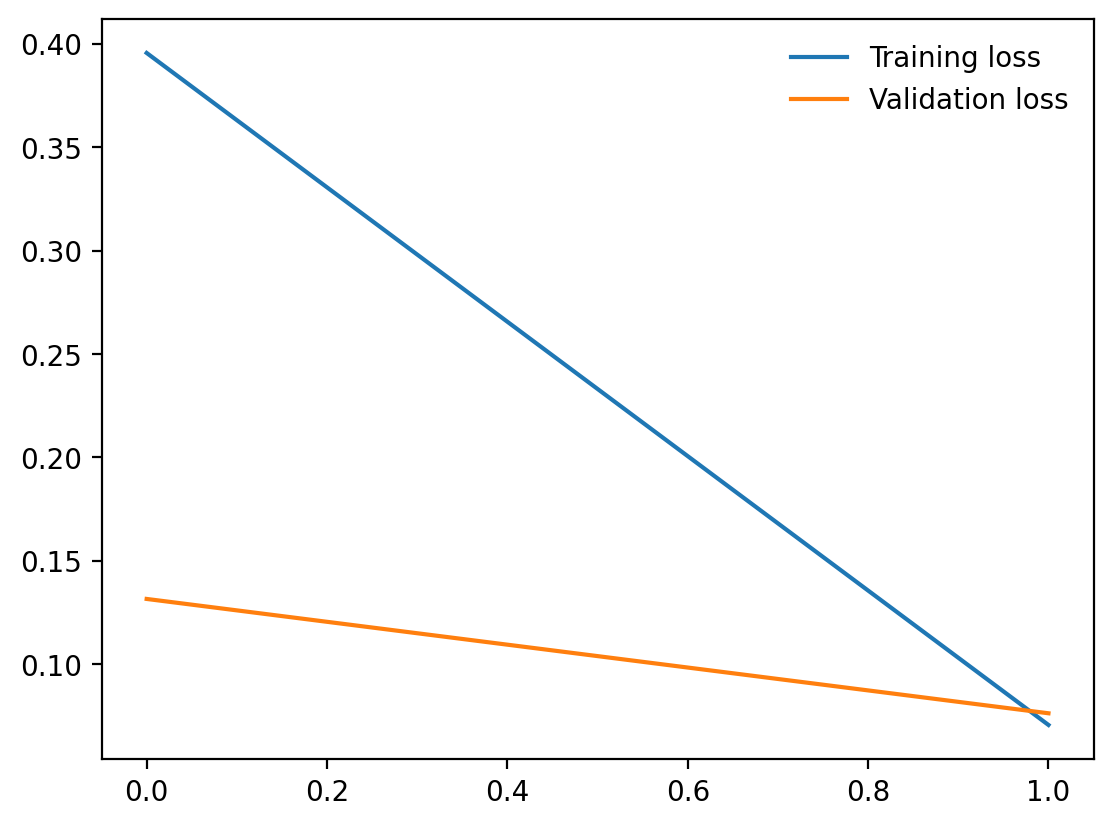

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

This graph looks decent to me. We're doing fairly well for our first model in PyTorch.

## Inference
You can see what out model is predicting here on the test data. You can try playing around with this function for different images. 

As expected our model seems to do well, infact really well.

In [12]:
# def view_classify(img, ps):
#     """
#     Function for viewing an image, and it's predicted classes.
#     """
#     ps = ps.data.numpy().squeeze()
#
#     fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
#     ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
#     ax1.axis('off')
#     ax2.barh(np.arange(10), ps)
#     ax2.set_aspect(0.1)
#     ax2.set_yticks(np.arange(10))
#     ax2.set_yticklabels(np.arange(10))
#     ax2.set_title('Class Probability')
#     ax2.set_xlim(0, 1.1)
#
#     plt.tight_layout()


In [13]:
# %matplotlib inline
#
# def make_prediction(data):
#     images, labels = next(iter(data))
#
#     img = images[42].view(1, 784)
#     # Turn off gradients to speed up this part
#     with torch.no_grad():
#         logps = model(img)
#
#     # Output of the network are log-probabilities, need to take exponential for probabilities
#     ps = torch.exp(logps)
#     view_classify(img.view(1, 28, 28), ps)
#
# make_prediction(test_loader)

## Preparing Test Data for Prediction

In [14]:
final_test_np = final_test.values/255
test_tn = torch.from_numpy(final_test_np.reshape((-1,1,28,28)))

In [15]:
# Create fake labels for convenience of passing into DataLoader
## CAUTION: There are other ways of doing this, I just did it this way
fake_labels = np.zeros(final_test_np.shape)
fake_labels = torch.from_numpy(fake_labels)

In [16]:
submission_tn_data = torch.utils.data.TensorDataset(test_tn.float(), fake_labels)

submission_loader = torch.utils.data.DataLoader(submission_tn_data, batch_size=1, shuffle = False)

In [17]:
# Seeing what our model does on test data
# make_prediction(submission_loader)

## Making Predictions on Test data

In [18]:
def prediction_func(data_loader):
    # Making it submission ready
    my_submission = [['ImageId', 'Label']]

    # Turn off gradients for validation
    with torch.no_grad():
        model.eval()
        image_id = 1
        for images, _ in data_loader:
            log_ps = model(images)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)

            for pred in top_class:
                my_submission.append([image_id, pred.item()])
                image_id += 1
    return my_submission

submission = prediction_func(submission_loader)

In [19]:
submission_df = pd.DataFrame(submission)
submission_df.columns = submission_df.iloc[0]
submission_df = submission_df.drop(0, axis=0)

In [20]:
def penultimate_layer_extract():
    # Extract the prediction weights and bias in the penultimate layer of CNNModel
    penultimate_weights_pred = model.fc1.weight.data
    penultimate_bias_pred = model.fc1.bias.data

    # Convert weights and bias to numpy
    weights_np_pred = penultimate_weights_pred.cpu().numpy()
    bias_np_pred = penultimate_bias_pred.cpu().numpy()

    # Since bias is a 1D array, reshape it to have the same number of dimensions as weights
    bias_np_pred = bias_np_pred.reshape(-1, 1)

    # Stack them horizontally to create a single numpy array
    combined_array_pred = np.hstack((weights_np_pred, bias_np_pred))

    # Convert to DataFrame
    df = pd.DataFrame(combined_array_pred)

    # Save to CSV
    df.to_csv("intro_penultimate_layer_pred.csv", index=False)

penultimate_layer_extract()

In [21]:
submission_df.to_csv("../results_pytorch/my_intro_submission.csv", index=False)

### **If you like this kernel or wish to fork it, please UPVOTE to show your support.**

**Authored by:**
[Abhinand](https://www.kaggle.com/abhinand05)